In [1]:
from __future__ import division, print_function
%matplotlib inline

import os
import sys
import cv2
import numpy as np
import pandas as pd
import skimage
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.interpolation import map_coordinates
from PIL import Image
import matplotlib.cm as cm

ROOT_DIR = os.path.abspath("./tf_unet/")
sys.path.append(ROOT_DIR)

plt.rcParams['image.cmap'] = 'gist_earth'
np.random.seed(98765)

In [2]:
#import util_unet
#file_names = "/home/soroushr/projects/Mask_RCNN/images-iceberg/20170808_132237_0e1f_3B_Analytic_tile_4900-1400 - Copy.jpg"
#file_names = "/home/soroushr/projects/Planet/planet-unet/train-all/20170808_132237_0e1f_3B_Analytic_tile_4900-2800_mask.png"
#img_original = skimage.io.imread(file_names)
#plt.imshow(img_original)
#len(img_original.shape)

#img_new = util_unet.reshape_image(img_original, 700, 700, mode="center")
#plt.imshow(img_new); plt.savefig('dont know1.png')

In [3]:
# Function to distort image
def elastic_transform(image, alpha, sigma, alpha_affine, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_ (with modifications).
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
         Convolutional Neural Networks applied to Visual Document Analysis", in
         Proc. of the International Conference on Document Analysis and
         Recognition, 2003.

     Based on https://gist.github.com/erniejunior/601cdf56d2b424757de5
    """
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape
    shape_size = shape[:2]
    
    # Random affine
    center_square = np.float32(shape_size) // 2
    square_size = min(shape_size) // 3
    
    pts1 = np.float32([center_square + square_size,
                      [center_square[0]+square_size, center_square[1]-square_size],
                       center_square - square_size])
    
    pts2 = pts1 + random_state.uniform(-alpha_affine, alpha_affine, size=pts1.shape).astype(np.float32)

    M = cv2.getAffineTransform(pts1, pts2)
    
    image = cv2.warpAffine(image, M, shape_size[::-1], borderMode=cv2.BORDER_REFLECT_101)

    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha

    x, y, z = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]), np.arange(shape[2]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1)), np.reshape(z, (-1, 1))

    return map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)


# Define function to draw a grid
def draw_grid(im, grid_size):
    # Draw grid lines
    for i in range(0, im.shape[1], grid_size):
        cv2.line(im, (i, 0), (i, im.shape[0]), color=(255,))
    for j in range(0, im.shape[0], grid_size):
        cv2.line(im, (0, j), (im.shape[1], j), color=(255,))

In [4]:
im = cv2.imread("./train-all-original/6s4yhdgi6lem2bkchojw.png", -1)
im_mask = cv2.imread("./train-all-original/6s4yhdgi6lem2bkchojw_mask.png", 0)

# Draw grid lines
draw_grid(im, 50)
draw_grid(im_mask, 50)

# Merge images into separete channels (shape will be (cols, rols, 2))
#im_merge = np.concatenate((im[...,None], im_mask[...,None]), axis=2)
im_merge = np.concatenate((im[...,0,None], im_mask[...,None]), axis=2)
print(im_merge.shape)

(768, 768, 2)


# Simple Deformation

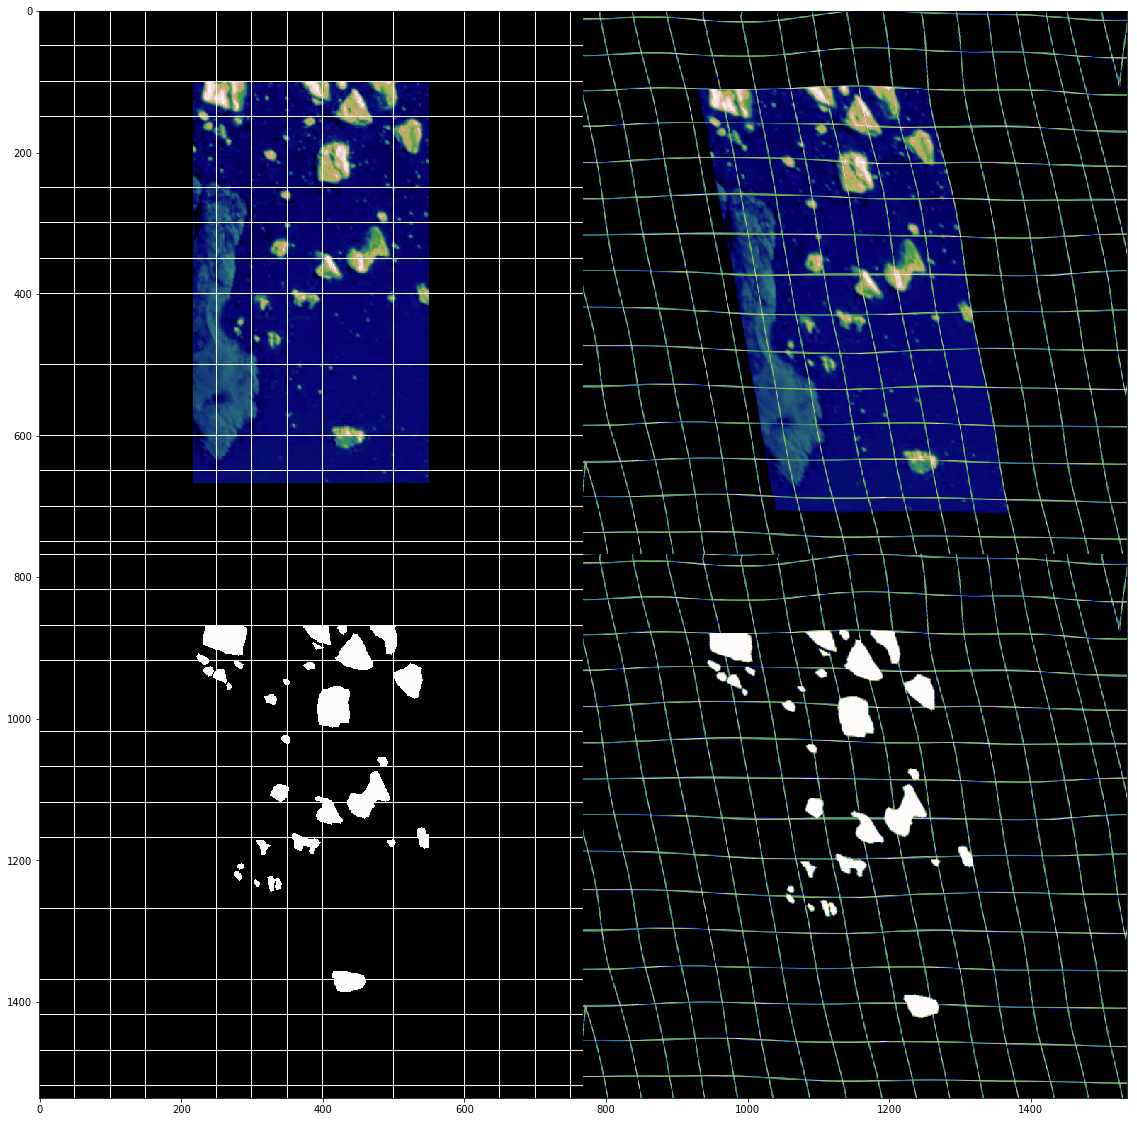

In [5]:
im_merge_t = elastic_transform(im_merge, im_merge.shape[1] * 2, im_merge.shape[1] * 0.08, im_merge.shape[1] * 0.08)

# Split image and mask
im_t = im_merge_t[...,0]
im_mask_t = im_merge_t[...,1]

# Display result
plt.figure(figsize = (20,20))
plt.imshow(np.c_[np.r_[im[...,0], im_mask], np.r_[im_t, im_mask_t]], cmap='gist_earth')

# More complex deformation

<Figure size 432x288 with 0 Axes>

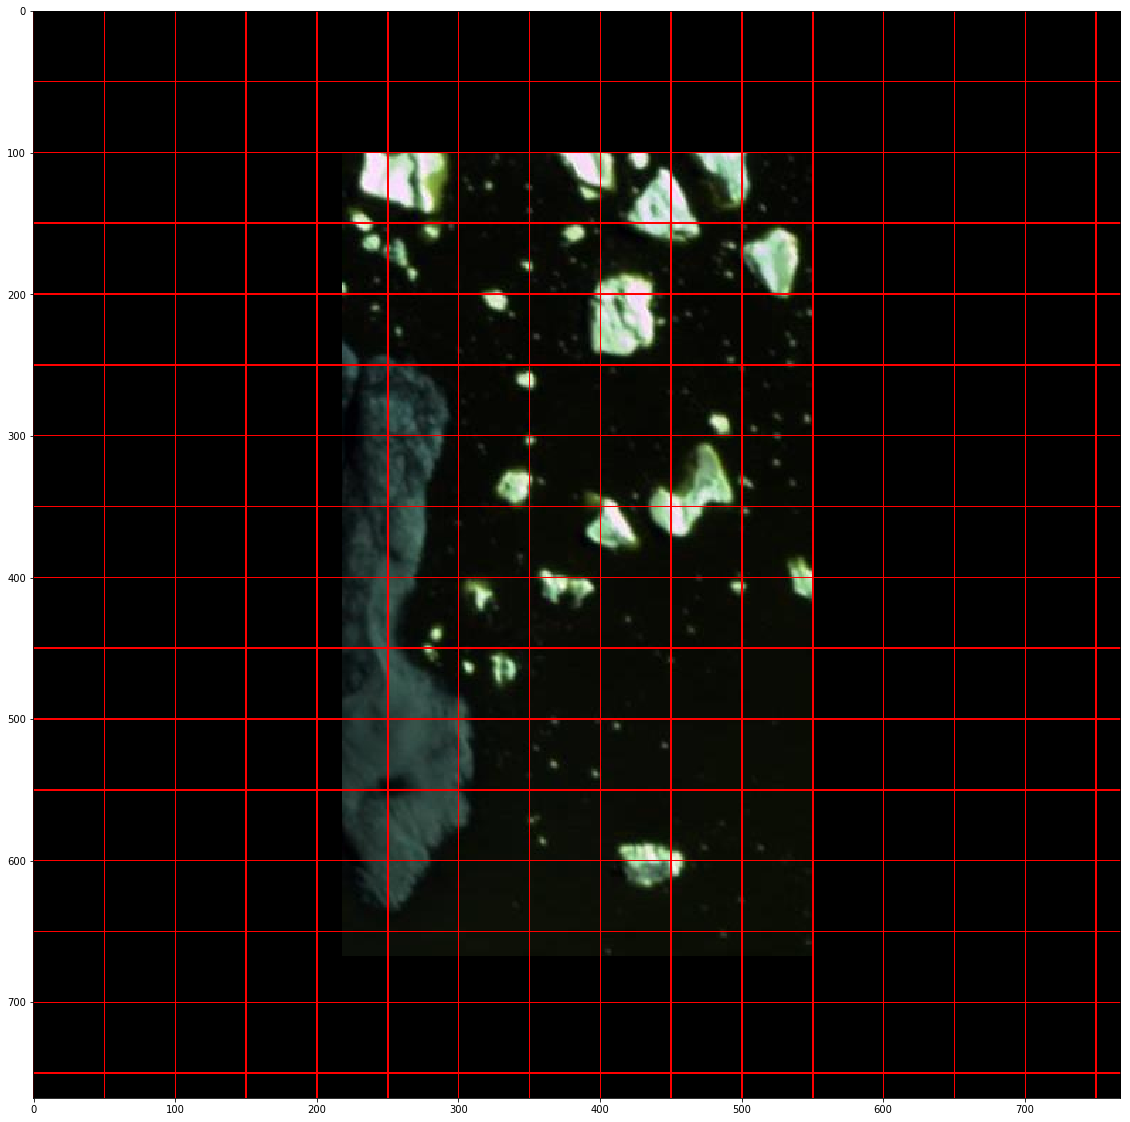

In [24]:
im_merge_t = elastic_transform(im_merge, im_merge.shape[1] * 3, im_merge.shape[1] * 0.04, im_merge.shape[1] * 0.09)

# Split image and mask
im_t = im_merge_t[...,0]
im_mask_t = im_merge_t[...,1]
plt.clf()
# Display result
plt.figure(figsize = (20,20))
#plt.imshow(np.c_[np.r_[im[...,0], im_mask], np.r_[im_t, im_mask_t]], cmap='gist_earth')
plt.imshow(im)

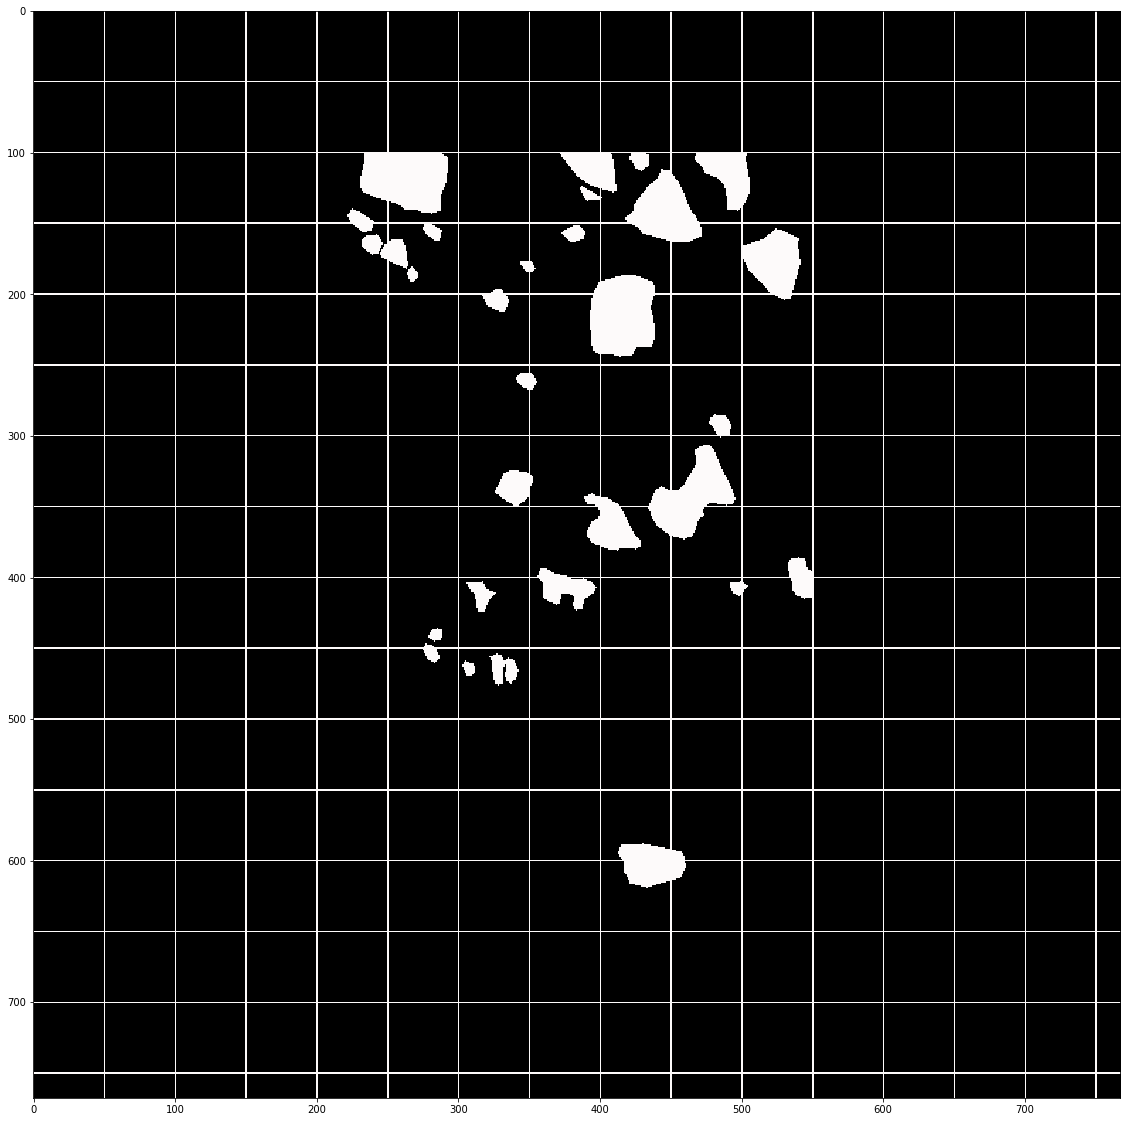

In [30]:
plt.figure(figsize = (20,20))
plt.imshow(im_mask)

In [7]:
image = cv2.imread("./train-all-original/6s4yhdgi6lem2bkchojw.png")
mask  = cv2.imread("./train-all-original/6s4yhdgi6lem2bkchojw_mask.png", -1)

print(image.shape)
print(mask.shape)
#image_elastic = elastic_transform(im, im.shape[1]*3, im.shape[1]*0.05, im.shape[1]*0.09)
#mask_elastic  = elastic_transform(im_mask, im_mask.shape[1]*3, im_mask.shape[1]*0.05, im_mask.shape[1]*0.09)

#plt.imsave('elastic-img.png',image_elastic)
#plt.imsave('elastic-img_mask.png',mask_elastic)

(700, 700, 3)
(700, 700)


In [8]:
# Function to distort image
def elastic_transform_both(image, mask, alpha, sigma, alpha_affine, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_ (with modifications).
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
         Convolutional Neural Networks applied to Visual Document Analysis", in
         Proc. of the International Conference on Document Analysis and
         Recognition, 2003.

     Based on https://gist.github.com/erniejunior/601cdf56d2b424757de5
    """
    if random_state is None:
        random_state = np.random.RandomState(None)

    if image.shape[:2] != mask.shape[:2]:
        raise Exception("image and mask must have the same size {}!={}".format(image.shape, mask.shape))

    shape = image.shape
    shape_size = shape[:2]

    # Random affine
    center_square = np.float32(shape_size) // 2
    square_size = min(shape_size) // 3
    
    pts1 = np.float32([center_square + square_size,
                      [center_square[0]+square_size, center_square[1]-square_size],
                       center_square - square_size])
    
    pts2 = pts1 + random_state.uniform(-alpha_affine, alpha_affine, size=pts1.shape).astype(np.float32)

    M = cv2.getAffineTransform(pts1, pts2)
    
    image = cv2.warpAffine(image, M, shape_size[::-1], borderMode=cv2.BORDER_REFLECT_101)
    mask  = cv2.warpAffine(mask,  M, shape_size[::-1], borderMode=cv2.BORDER_REFLECT_101)

    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha

    x, y, z = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]), np.arange(shape[2]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1)), np.reshape(z, (-1, 1))

    image_elastic = map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)
    mask_elastic  = map_coordinates(mask, indices, order=1, mode='reflect').reshape(shape)
    
    mask_elastic = np.where(mask_elastic>128, 255, 0)[...,0]
    
    return image_elastic, mask_elastic

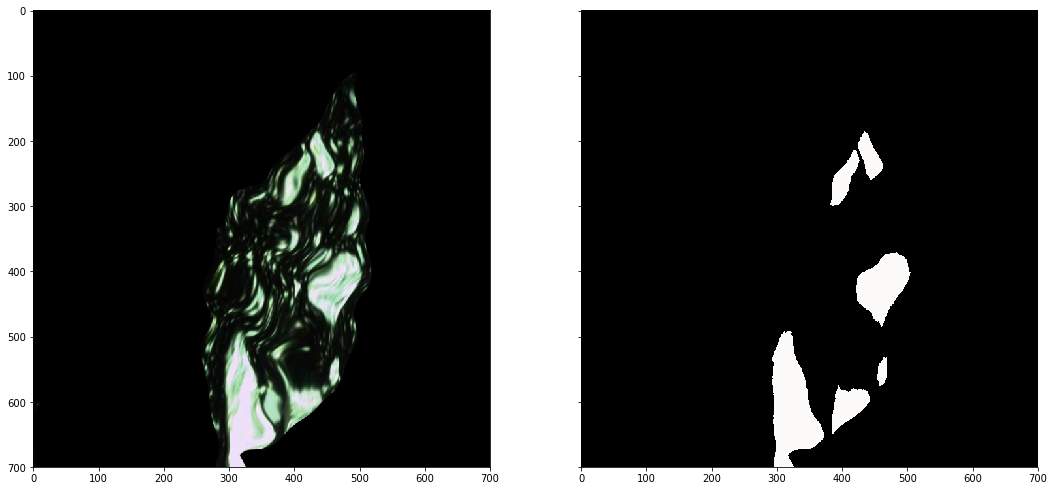

In [9]:
image = cv2.imread("./train-all-original/0gtuqa3cwabwdktz5ppx.png")
mask  = cv2.imread("./train-all-original/0gtuqa3cwabwdktz5ppx_mask.png")

image_elastic, mask_elastic = elastic_transform_both(image, mask,
                                                     image.shape[1]*3,
                                                     image.shape[1]*0.03,
                                                     image.shape[1]*0.25)

plt.imsave('elastic-img.png',image_elastic)
plt.imsave('elastic-img_mask.png', mask_elastic)

fig, ax = plt.subplots(1,2, sharey=True, figsize=(18,18))
ax[0].imshow(image_elastic, aspect="equal")
ax[1].imshow(mask_elastic, aspect="equal")